# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [4]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()
weights = models.EfficientNet_V2_L_Weights.IMAGENET1K_V1
model = models.efficientnet_v2_l(weights=weights)
transforms = weights.transforms()

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [5]:
# Normalize images
data_aug = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

data_in = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [6]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.full((len(self.file_names), 8 * 8), 12)
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =piece['category_id']
            self.boards[idx][row*8+col] = piceId
        #print(self.boards[0])
        if partition == 'train':#['chessred2k']
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names#[:30]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            if i %1000 ==0:
                print(f"Loading image {i+1}/{len(self.file_names)}")
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)


Number of train images: 6479
Loading image 1/6479
Loading image 1001/6479
Loading image 2001/6479
Loading image 3001/6479
Loading image 4001/6479
Loading image 5001/6479
Loading image 6001/6479
Number of valid images: 2192
Loading image 1/2192
Loading image 1001/2192
Loading image 2001/2192


In [7]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 2
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)


Using cuda device


torch.Size([2, 480, 480, 3])
tensor([ 1, 12,  3,  5,  4,  3,  2,  1,  0,  0,  0, 12,  0,  0,  0,  0, 12, 12,
         2, 12, 12, 12, 12, 12, 12, 12, 12,  0, 12, 12, 12, 12, 12, 12, 12,  6,
        12, 12, 12, 12, 12, 12, 12, 12, 12,  8, 12, 12,  6,  6,  6, 12,  6,  6,
         6,  6,  7,  8,  9, 11, 10,  9, 12,  7])
tensor([[ 1, 12,  3,  5,  4,  3,  2,  1],
        [ 0,  0,  0, 12,  0,  0,  0,  0],
        [12, 12,  2, 12, 12, 12, 12, 12],
        [12, 12, 12,  0, 12, 12, 12, 12],
        [12, 12, 12,  6, 12, 12, 12, 12],
        [12, 12, 12, 12, 12,  8, 12, 12],
        [ 6,  6,  6, 12,  6,  6,  6,  6],
        [ 7,  8,  9, 11, 10,  9, 12,  7]])


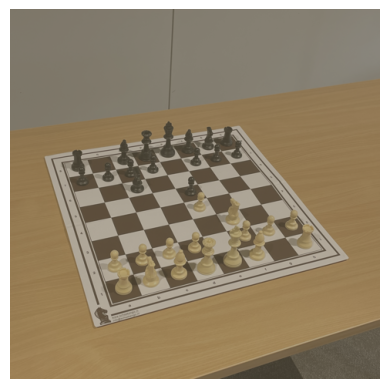

In [8]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels[0])
    print(labels[0].reshape(8, 8))
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
size_parameters = 512
print(model.classifier)
model.classifier  = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, 64),
    nn.Sigmoid()
)
# black 
model.to(device)

Using cuda device
Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

## Train the model

Define function to perform one iteration

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score

def calculate_chess_accuracy(y_true, y_pred):
    """
    Calculate chess board accuracy metrics
    Args:
        y_true: Ground truth (batch_size, 64)
        y_pred: Model predictions (batch_size, 64)
    Returns:
        overall_acc: Total accuracy across all squares
        square_acc: List of accuracies per square
    """
    # Convert -0 to 0 (equivalent in floating point)
    y_true = np.where(y_true == -0., 0., y_true)
    y_pred = np.where(y_pred == -0., 0., y_pred)
    
    # Binarize predictions if using raw outputs
    y_pred = (y_pred > 0.5).astype(float)
    
    # Calculate overall accuracy (all squares combined)
    overall_acc = accuracy_score(y_true.flatten(), y_pred.flatten())
    
    # Calculate accuracy per square
    square_acc = []
    for square_idx in range(64):
        acc = accuracy_score(y_true[:, square_idx], y_pred[:, square_idx])
        square_acc.append(acc)
    
    return overall_acc, square_acc

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).float() # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred * 12)#.round() # Scale [0,1] → [1,32] and round
          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          #print(scaled_pred,y)
          loss = loss_fn(scaled_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.extend(scaled_pred.cpu())
          #print(preds)
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.extend(y.cpu())
    all_preds = torch.cat(preds).round()
    all_labels = torch.cat(labels)
    # Suggested fix:
    matches = (all_preds == all_labels).cpu().numpy()
    accuracy = np.mean(matches) * 100
    #print("Mean Correct: :",matches)
    """print(all_preds.shape,all_labels.shape)
    print(all_preds,all_labels)
      # Calculate exact match accuracy (PyTorch way)
    exact_matches = (all_preds == all_labels).all(dim=1).float().mean().item()
    
    # Calculate element-wise accuracy
    element_acc = (all_preds == all_labels).float().mean().item()
    print(exact_matches,element_acc)"""
    
    return total_loss / num_batches, accuracy

Define function to train a model

In [11]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

In [12]:
test = [1, 2, 3]
test1 = [1, 0, 0]

# Create boolean array of matches
condition_array = np.array(test) == np.array(test1)

# Calculate percentage of correct elements
percentage_correct = np.mean(condition_array) * 100

print("Matching elements array:", condition_array)
print(f"Percentage correct: {percentage_correct:.1f}%")

Matching elements array: [ True False False]
Percentage correct: 33.3%


Define loss, optimizer and train the model

In [ ]:
# Define loss function
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 100

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 3239/3239 [12:48<00:00,  4.22it/s]


Train loss: 15.10660 	 Train acc: 2.71689


100%|██████████| 1096/1096 [01:16<00:00, 14.36it/s]


Val loss: 14.68237 	 Val acc: 5.18932

Epoch 2


100%|██████████| 3239/3239 [12:48<00:00,  4.21it/s]


Train loss: 14.97432 	 Train acc: 1.84012


100%|██████████| 1096/1096 [01:17<00:00, 14.21it/s]


Val loss: 15.70944 	 Val acc: 14.72899

Epoch 3


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.96160 	 Train acc: 1.81793


100%|██████████| 1096/1096 [01:17<00:00, 14.11it/s]


Val loss: 15.44980 	 Val acc: 13.02535

Epoch 4


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.95223 	 Train acc: 1.80563


100%|██████████| 1096/1096 [01:17<00:00, 14.15it/s]


Val loss: 15.12752 	 Val acc: 9.46482

Epoch 5


100%|██████████| 3239/3239 [12:50<00:00,  4.21it/s]


Train loss: 14.95522 	 Train acc: 1.87413


100%|██████████| 1096/1096 [01:17<00:00, 14.08it/s]


Val loss: 15.74148 	 Val acc: 15.55657

Epoch 6


100%|██████████| 3239/3239 [12:51<00:00,  4.20it/s]


Train loss: 14.94429 	 Train acc: 1.82059


100%|██████████| 1096/1096 [01:17<00:00, 14.08it/s]


Val loss: 14.85174 	 Val acc: 6.14522

Epoch 7


100%|██████████| 3239/3239 [12:47<00:00,  4.22it/s]


Train loss: 14.94362 	 Train acc: 1.82059


100%|██████████| 1096/1096 [01:18<00:00, 14.03it/s]


Val loss: 15.33287 	 Val acc: 11.25470

Epoch 8


100%|██████████| 3239/3239 [12:47<00:00,  4.22it/s]


Train loss: 14.94140 	 Train acc: 1.82420


100%|██████████| 1096/1096 [01:17<00:00, 14.10it/s]


Val loss: 15.34935 	 Val acc: 12.34674

Epoch 9


100%|██████████| 3239/3239 [12:47<00:00,  4.22it/s]


Train loss: 14.93884 	 Train acc: 1.82541


100%|██████████| 1096/1096 [01:18<00:00, 13.98it/s]


Val loss: 15.27660 	 Val acc: 10.99025

Epoch 10


100%|██████████| 3239/3239 [12:50<00:00,  4.21it/s]


Train loss: 14.93806 	 Train acc: 1.83072


100%|██████████| 1096/1096 [01:18<00:00, 13.96it/s]


Val loss: 14.97050 	 Val acc: 7.95649

Epoch 11


100%|██████████| 3239/3239 [12:46<00:00,  4.22it/s]


Train loss: 14.94003 	 Train acc: 1.84278


100%|██████████| 1096/1096 [01:18<00:00, 14.00it/s]


Val loss: 14.66740 	 Val acc: 4.17427

Epoch 12


100%|██████████| 3239/3239 [12:48<00:00,  4.21it/s]


Train loss: 14.93303 	 Train acc: 1.81938


100%|██████████| 1096/1096 [01:18<00:00, 13.93it/s]


Val loss: 15.41280 	 Val acc: 12.00174

Epoch 13


100%|██████████| 3239/3239 [12:46<00:00,  4.23it/s]


Train loss: 14.93591 	 Train acc: 1.82444


100%|██████████| 1096/1096 [01:18<00:00, 13.98it/s]


Val loss: 15.13843 	 Val acc: 10.25676

Epoch 14


100%|██████████| 3239/3239 [12:48<00:00,  4.22it/s]


Train loss: 14.93223 	 Train acc: 1.82806


100%|██████████| 1096/1096 [01:18<00:00, 13.94it/s]


Val loss: 15.50906 	 Val acc: 13.34041

Epoch 15


100%|██████████| 3239/3239 [12:46<00:00,  4.23it/s]


Train loss: 14.93055 	 Train acc: 1.83892


100%|██████████| 1096/1096 [01:18<00:00, 13.96it/s]


Val loss: 15.66826 	 Val acc: 14.00547

Epoch 16


100%|██████████| 3239/3239 [12:48<00:00,  4.22it/s]


Train loss: 14.93161 	 Train acc: 1.82975


100%|██████████| 1096/1096 [01:18<00:00, 13.90it/s]


Val loss: 15.00019 	 Val acc: 8.17105

Epoch 17


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.93071 	 Train acc: 1.82179


100%|██████████| 1096/1096 [01:18<00:00, 13.95it/s]


Val loss: 14.98222 	 Val acc: 8.17176

Epoch 18


100%|██████████| 3239/3239 [12:46<00:00,  4.22it/s]


Train loss: 14.93301 	 Train acc: 1.83530


100%|██████████| 1096/1096 [01:18<00:00, 13.96it/s]


Val loss: 15.41362 	 Val acc: 12.60265

Epoch 19


100%|██████████| 3239/3239 [12:46<00:00,  4.23it/s]


Train loss: 14.92908 	 Train acc: 1.82758


100%|██████████| 1096/1096 [01:18<00:00, 13.95it/s]


Val loss: 14.85316 	 Val acc: 6.31558

Epoch 20


100%|██████████| 3239/3239 [12:48<00:00,  4.21it/s]


Train loss: 14.92915 	 Train acc: 1.82396


100%|██████████| 1096/1096 [01:18<00:00, 13.90it/s]


Val loss: 15.32654 	 Val acc: 11.10145

Epoch 21


100%|██████████| 3239/3239 [12:48<00:00,  4.22it/s]


Train loss: 14.93048 	 Train acc: 1.82830


100%|██████████| 1096/1096 [01:18<00:00, 13.91it/s]


Val loss: 14.75621 	 Val acc: 5.30052

Epoch 22


100%|██████████| 3239/3239 [12:47<00:00,  4.22it/s]


Train loss: 14.92869 	 Train acc: 1.83650


100%|██████████| 1096/1096 [01:18<00:00, 13.94it/s]


Val loss: 14.48181 	 Val acc: 1.66372

Epoch 23


100%|██████████| 3239/3239 [12:47<00:00,  4.22it/s]


Train loss: 14.92913 	 Train acc: 1.83216


100%|██████████| 1096/1096 [01:18<00:00, 13.95it/s]


Val loss: 14.46459 	 Val acc: 1.60456

Epoch 24


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.92912 	 Train acc: 1.83506


100%|██████████| 1096/1096 [01:18<00:00, 13.91it/s]


Val loss: 14.48934 	 Val acc: 1.67513

Epoch 25


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.92472 	 Train acc: 1.82854


100%|██████████| 1096/1096 [01:18<00:00, 13.93it/s]


Val loss: 14.44996 	 Val acc: 1.67299

Epoch 26


100%|██████████| 3239/3239 [12:47<00:00,  4.22it/s]


Train loss: 14.92840 	 Train acc: 1.83144


100%|██████████| 1096/1096 [01:18<00:00, 13.93it/s]


Val loss: 14.52843 	 Val acc: 1.73215

Epoch 27


100%|██████████| 3239/3239 [12:48<00:00,  4.21it/s]


Train loss: 14.92885 	 Train acc: 1.84036


100%|██████████| 1096/1096 [01:18<00:00, 13.93it/s]


Val loss: 14.48719 	 Val acc: 1.65160

Epoch 28


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.92774 	 Train acc: 1.84663


100%|██████████| 1096/1096 [01:18<00:00, 13.92it/s]


Val loss: 14.48390 	 Val acc: 1.58816

Epoch 29


100%|██████████| 3239/3239 [12:47<00:00,  4.22it/s]


Train loss: 14.92621 	 Train acc: 1.84229


100%|██████████| 1096/1096 [01:18<00:00, 13.92it/s]


Val loss: 14.53918 	 Val acc: 1.63307

Epoch 30


100%|██████████| 3239/3239 [12:48<00:00,  4.22it/s]


Train loss: 14.92603 	 Train acc: 1.83964


100%|██████████| 1096/1096 [01:18<00:00, 13.94it/s]


Val loss: 14.48886 	 Val acc: 1.66087

Epoch 31


100%|██████████| 3239/3239 [12:47<00:00,  4.22it/s]


Train loss: 14.92540 	 Train acc: 1.82662


100%|██████████| 1096/1096 [01:18<00:00, 13.93it/s]


Val loss: 14.47715 	 Val acc: 1.71290

Epoch 32


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.92675 	 Train acc: 1.84350


100%|██████████| 1096/1096 [01:18<00:00, 13.94it/s]


Val loss: 14.53301 	 Val acc: 1.64661

Epoch 33


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.92715 	 Train acc: 1.84326


100%|██████████| 1096/1096 [01:18<00:00, 13.92it/s]


Val loss: 14.50643 	 Val acc: 1.61240

Epoch 34


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.92620 	 Train acc: 1.84784


100%|██████████| 1096/1096 [01:18<00:00, 13.90it/s]


Val loss: 14.45021 	 Val acc: 1.66800

Epoch 35


100%|██████████| 3239/3239 [12:48<00:00,  4.22it/s]


Train loss: 14.92582 	 Train acc: 1.84929


100%|██████████| 1096/1096 [01:18<00:00, 13.90it/s]


Val loss: 14.54940 	 Val acc: 1.65588

Epoch 36


100%|██████████| 3239/3239 [12:48<00:00,  4.21it/s]


Train loss: 14.92466 	 Train acc: 1.85194


100%|██████████| 1096/1096 [01:18<00:00, 13.91it/s]


Val loss: 14.51832 	 Val acc: 1.68582

Epoch 37


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.92407 	 Train acc: 1.83216


100%|██████████| 1096/1096 [01:18<00:00, 13.89it/s]


Val loss: 14.49378 	 Val acc: 1.67940

Epoch 38


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.92652 	 Train acc: 1.84591


100%|██████████| 1096/1096 [01:18<00:00, 13.91it/s]


Val loss: 14.51911 	 Val acc: 1.66871

Epoch 39


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.92327 	 Train acc: 1.84350


100%|██████████| 1096/1096 [01:18<00:00, 13.91it/s]


Val loss: 14.51524 	 Val acc: 1.69295

Epoch 40


100%|██████████| 3239/3239 [12:48<00:00,  4.21it/s]


Train loss: 14.92373 	 Train acc: 1.84543


100%|██████████| 1096/1096 [01:19<00:00, 13.86it/s]


Val loss: 14.49006 	 Val acc: 1.58959

Epoch 41


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.92477 	 Train acc: 1.83843


100%|██████████| 1096/1096 [01:18<00:00, 13.92it/s]


Val loss: 14.49616 	 Val acc: 1.65802

Epoch 42


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.92454 	 Train acc: 1.84639


100%|██████████| 1096/1096 [01:18<00:00, 13.90it/s]


Val loss: 14.51492 	 Val acc: 1.81769

Epoch 43


100%|██████████| 3239/3239 [12:51<00:00,  4.20it/s]


Train loss: 14.92265 	 Train acc: 1.83892


100%|██████████| 1096/1096 [01:19<00:00, 13.87it/s]


Val loss: 14.45402 	 Val acc: 1.65659

Epoch 44


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.92500 	 Train acc: 1.83554


100%|██████████| 1096/1096 [01:19<00:00, 13.84it/s]


Val loss: 14.46429 	 Val acc: 1.66657

Epoch 45


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.92715 	 Train acc: 1.85387


100%|██████████| 1096/1096 [01:18<00:00, 13.91it/s]


Val loss: 15.84834 	 Val acc: 15.91583

Epoch 46


100%|██████████| 3239/3239 [12:49<00:00,  4.21it/s]


Train loss: 14.92279 	 Train acc: 1.83216


100%|██████████| 1096/1096 [01:18<00:00, 13.90it/s]


Val loss: 15.58410 	 Val acc: 13.96556

Epoch 47


100%|██████████| 3239/3239 [12:50<00:00,  4.21it/s]


Train loss: 14.92257 	 Train acc: 1.85652


100%|██████████| 1096/1096 [01:20<00:00, 13.54it/s]


Val loss: 15.74919 	 Val acc: 14.08317

Epoch 48


100%|██████████| 3239/3239 [13:20<00:00,  4.05it/s]


Train loss: 14.92382 	 Train acc: 1.83144


100%|██████████| 1096/1096 [01:21<00:00, 13.46it/s]


Val loss: 16.28905 	 Val acc: 20.14499

Epoch 49


100%|██████████| 3239/3239 [13:27<00:00,  4.01it/s]


Train loss: 14.91986 	 Train acc: 1.83554


 24%|██▍       | 263/1096 [00:20<01:02, 13.29it/s]

## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [ ]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

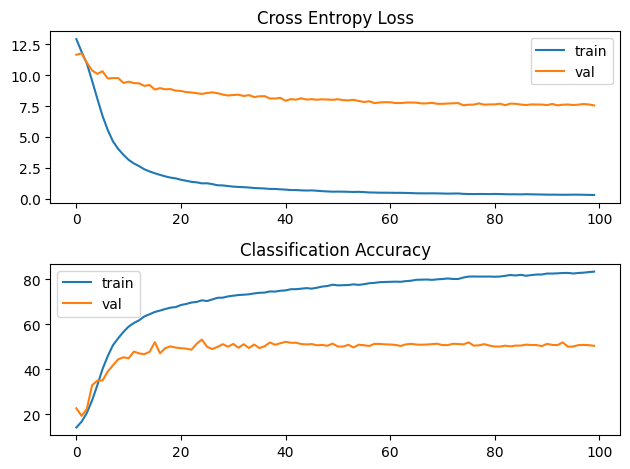

In [ ]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [ ]:
# Load the best model
# TODO
test_dataset = ChessDataset('..', 'test', data_in)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
# Evaluate model on test data
# TODO
#free cuda memory
torch.cuda.empty_cache()
def test(dataloader):
    preds = []
    labels = []
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        predsTmp = pred.cpu().detach().numpy()*12
        preds.extend(predsTmp.round().astype(int).squeeze())
        #print(pred.cpu())
        #print(y.cpu())
        original_values =y.cpu().detach().numpy()
        labels.extend(original_values)
    print(labels[:1],preds[:1])
    preds_np = np.array(preds)
    labels_np = np.array(labels)
    matches = (preds_np == labels_np)
    accuracy = np.mean(matches) * 100
    return accuracy
test_loss = test(test_dataloader)
print(f"Test loss: {test_loss:.3f}")

100%|██████████| 142/142 [00:14<00:00,  9.87it/s]

[array([ 1,  2,  3,  5,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  8,  9, 11, 10,  9,  8,  7])] [array([ 1,  2,  3,  5,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  8,  9, 11, 10,  9,  8,  7])]
Test loss: 47.867


  0%|          | 0/142 [00:00<?, ?it/s]

[[ 1.  2.  3.  5.  4.  3.  2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [ 6.  6.  6.  6.  6.  6.  6.  6.]
 [ 7.  8.  9. 11. 10.  9.  8.  7.]]
[[ 1  2  3  5  4  3  2  1]
 [ 0  0  0  0  0  0  0  0]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [ 6  6  6  6  6  6  6  6]
 [ 7  8  9 11 10  9  8  7]]


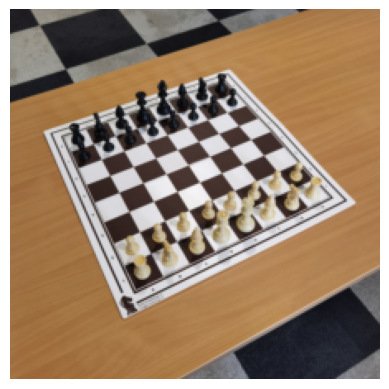

  0%|          | 0/142 [00:00<?, ?it/s]


In [ ]:
torch.cuda.empty_cache()
def results_analyse(dataloader):
    preds = []
    labels = []
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        predsTmp = pred.cpu().detach().numpy()*12
        print(predsTmp[0].round().reshape(8, 8))
        print(y.cpu()[0].reshape(8, 8).numpy())
        #print(pred.cpu())
        #print(y.cpu())
        original_values =y.cpu()
        labels.extend(original_values)
        imgs = X.cpu()
        imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
        plt.imshow(imgs[0])
        plt.axis('off')
        plt.show()
        break
results_analyse(test_dataloader)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?